In [1]:
import torch
import glob
import os
from nngeometry.object import PVector, PushForwardImplicit
from nngeometry.generator import Jacobian
import copy
from tasks import get_task
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from tasks import extract_small_loader
from margin_utils import margin_mean

path = './results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0'

ckpt_paths = sorted(glob.glob(os.path.join(path, 'checkpoint_*')))

In [2]:
n_examples = 250

In [3]:
with open('cifar10-cscores-orig-order.npz', 'rb') as f:
    d = np.load(f)
    cscores = d['scores']
    labels = d['labels']

In [4]:
cscores = cscores[:n_examples]
labels = labels[:n_examples]
order = cscores.argsort()
ranks = order.argsort()

In [5]:
Args = namedtuple('Args', 'task batch_size depth width batch_norm')
args = Args(task='cifar10_resnet18', batch_size=125, depth=0, width=0, batch_norm=False)
_, dataloaders, criterion = get_task(args)
dataloaders['mini_train'] = extract_small_loader(dataloaders['train_deterministic'], n_examples, n_examples)

Files already downloaded and verified
Files already downloaded and verified


./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_10_0.pt


/home/mila/g/georgeth/pytenv3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


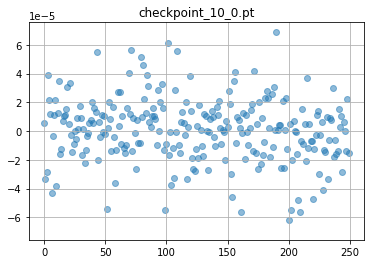

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_20_125.pt


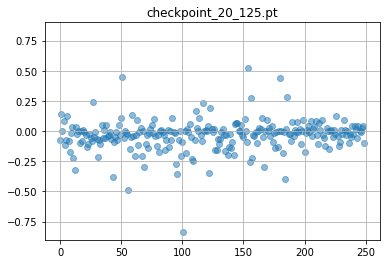

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_30_436.pt


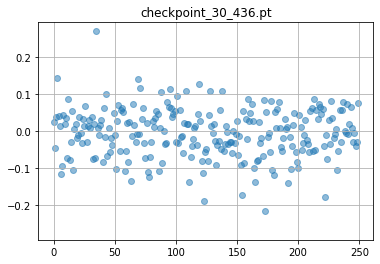

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_40_995.pt


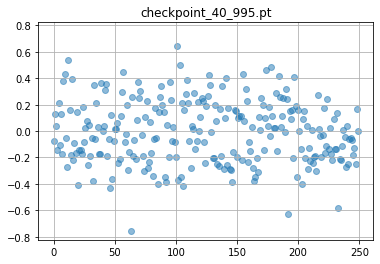

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_50_1823.pt


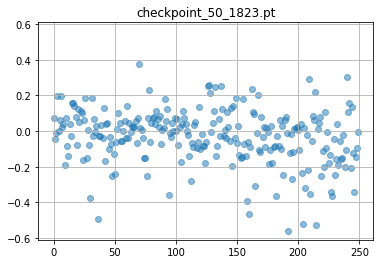

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_60_2891.pt


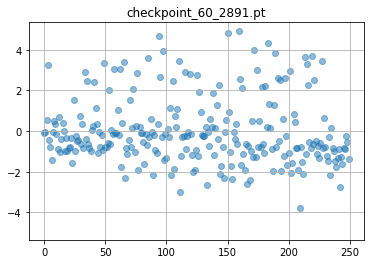

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_70_4197.pt


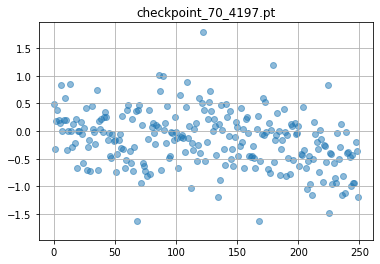

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_80_6129.pt


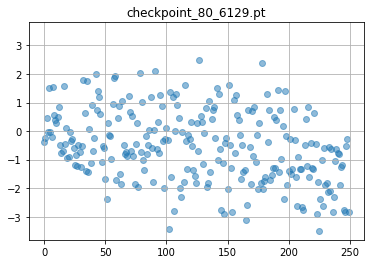

./results/alpha=1.0,batch_size=125,depth=0,diff=0.0,diff_type=random,epochs=60,l2=0.0,lr=0.05,mom=0.0,seed=1,task=cifar10_resnet18,width=0/checkpoint_90_7754.pt


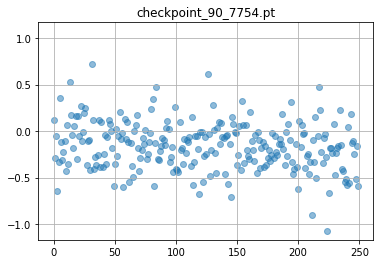

In [6]:
def analyze(loader, model, model_0, optimizer0, alpha=1):
    deltas_lin = []
    deltas_nonlin = []
    w_0 = PVector.from_model(model).clone().detach()

    for inputs, targets, logits in iter(loader):

        if len(deltas_lin) == 2:
            break

        optimizer = optimizer0
        optimizer.zero_grad()
        outputs = model(inputs)
        with torch.no_grad():
            outputs -= model_0(inputs).detach()
        outputs_alpha = alpha * outputs

        loss = criterion(outputs_alpha + logits, targets)
        grad_f = torch.autograd.grad(loss, outputs_alpha)[0]
        outputs.backward(grad_f)

        optimizer.step()
        optimizer.zero_grad()

        inputs, targets, logits = next(iter(dataloaders['mini_train']))
        outputs_after = model(inputs)
        with torch.no_grad():
            outputs_after -= model_0(inputs).detach()

        w_after = PVector.from_model(model).clone().detach()

        w_0.copy_to_model(model)

        outputs_before = model(inputs)
        with torch.no_grad():
            outputs_before -= model_0(inputs).detach()

        with torch.no_grad():
            deltas_nonlin.append(outputs_after - outputs_before)

        generator = Jacobian(model=model, n_output=10)
        pf = PushForwardImplicit(generator, examples=dataloaders['mini_train'])
        d_logits = pf.mv(w_after - w_0)

        deltas_lin.append(d_logits.get_flat_representation().t())
    
    return deltas_lin, deltas_nonlin
        

for ckpt_path in ckpt_paths:

    print(ckpt_path)
    ckpt = torch.load(ckpt_path)

    deltas_lin, deltas_nonlin = analyze(dataloaders['train'], ckpt['model'], ckpt['model_0'],
                                        ckpt['optimizer'])

    delta_lin_sum = sum(deltas_lin)
    delta_nonlin_sum = sum(deltas_nonlin)

    diff = delta_nonlin_sum - delta_lin_sum

    plt.figure()
    plt.scatter(ranks, margin_mean(diff.cpu(), labels), alpha=.5)
    # plt.scatter(ranks, diff.cpu()[np.arange(n_examples), labels], alpha=.5)
    plt.title(ckpt_path.split('/')[-1])
    plt.grid()

    ylims = plt.ylim()
    ylim_max = max(-ylims[0], ylims[1])
    plt.ylim(-ylim_max, ylim_max)
    plt.show()